Analyze a ultrasound probe's signal-to-noise ratio over vertical distance.  The US video must be centered over the vertical wire group in the CIRS 040GSE phantom.


In [1]:
%load_ext autoreload
%autoreload 2

import itk
from glob import glob
import usqc.data
import usqc.qc
import usqc.phantom
from usqc.manuscript import PROBE_ORDERED, PROBE_PRETTY


In [2]:

probes = ['butterfly-iq', 'clarius-l7hd', 'sonoque-l5c', 'sonivate', 'interson-spl01']
snr_map = {}
snr_imgs = {}
signal_noise_map = {}
for p in probes:
    fps = glob(f'../data/phantom_study-202201/annotated/{p}/snr*points.pickle')
    tmp1 = []
    tmp2 = []
    tmp3 = []
    for f in fps:
        z = usqc.qc.load_and_calculate_snr(f)
        x, y, snr_img, signal, noise = z['static']
        tmp1.append((x,y))
        tmp2.append(snr_img)
        tmp3.append((signal, noise))
    snr_map[p] = tmp1
    snr_imgs[p] = tmp2
    signal_noise_map[p] = tmp3


divide by zero encountered in divide


In [3]:
import scipy as sp
import scipy.interpolate
import numpy as np
def average_curves(xs, ys, spacing=None):
    '''
    Returns an average curve defined by xy and ys.
    
    Parameters
    ----------
    xs : list of ndarray
        Each element is a the x-values for an individual curve
    ys : list of ndarray
        Each element are the y-values for an individual curve
    
    Returns
    -------
    ts : ndarray
        Sample points along average curve, clamped between the maximum starting point and minimum ending
        point provided
    yp : ndarray
        Interpolated average curve values sampled at ts
    '''
    clampx = (np.max([ x[0] for x in xs ]), np.min([ x[-1] for x in xs]))
    spacing = spacing if spacing is not None else np.min([ x[1] - x[0] for x in xs] )

    ts = np.linspace(clampx[0], clampx[1], num=round((clampx[1] - clampx[0])/spacing))
    
    interps = [ sp.interpolate.interp1d(x, y) for x, y in zip(xs, ys) ] # linear interpolation
    yp = [ np.mean([ i(t) for i in interps]) for t in ts ]
    
    return ts, yp

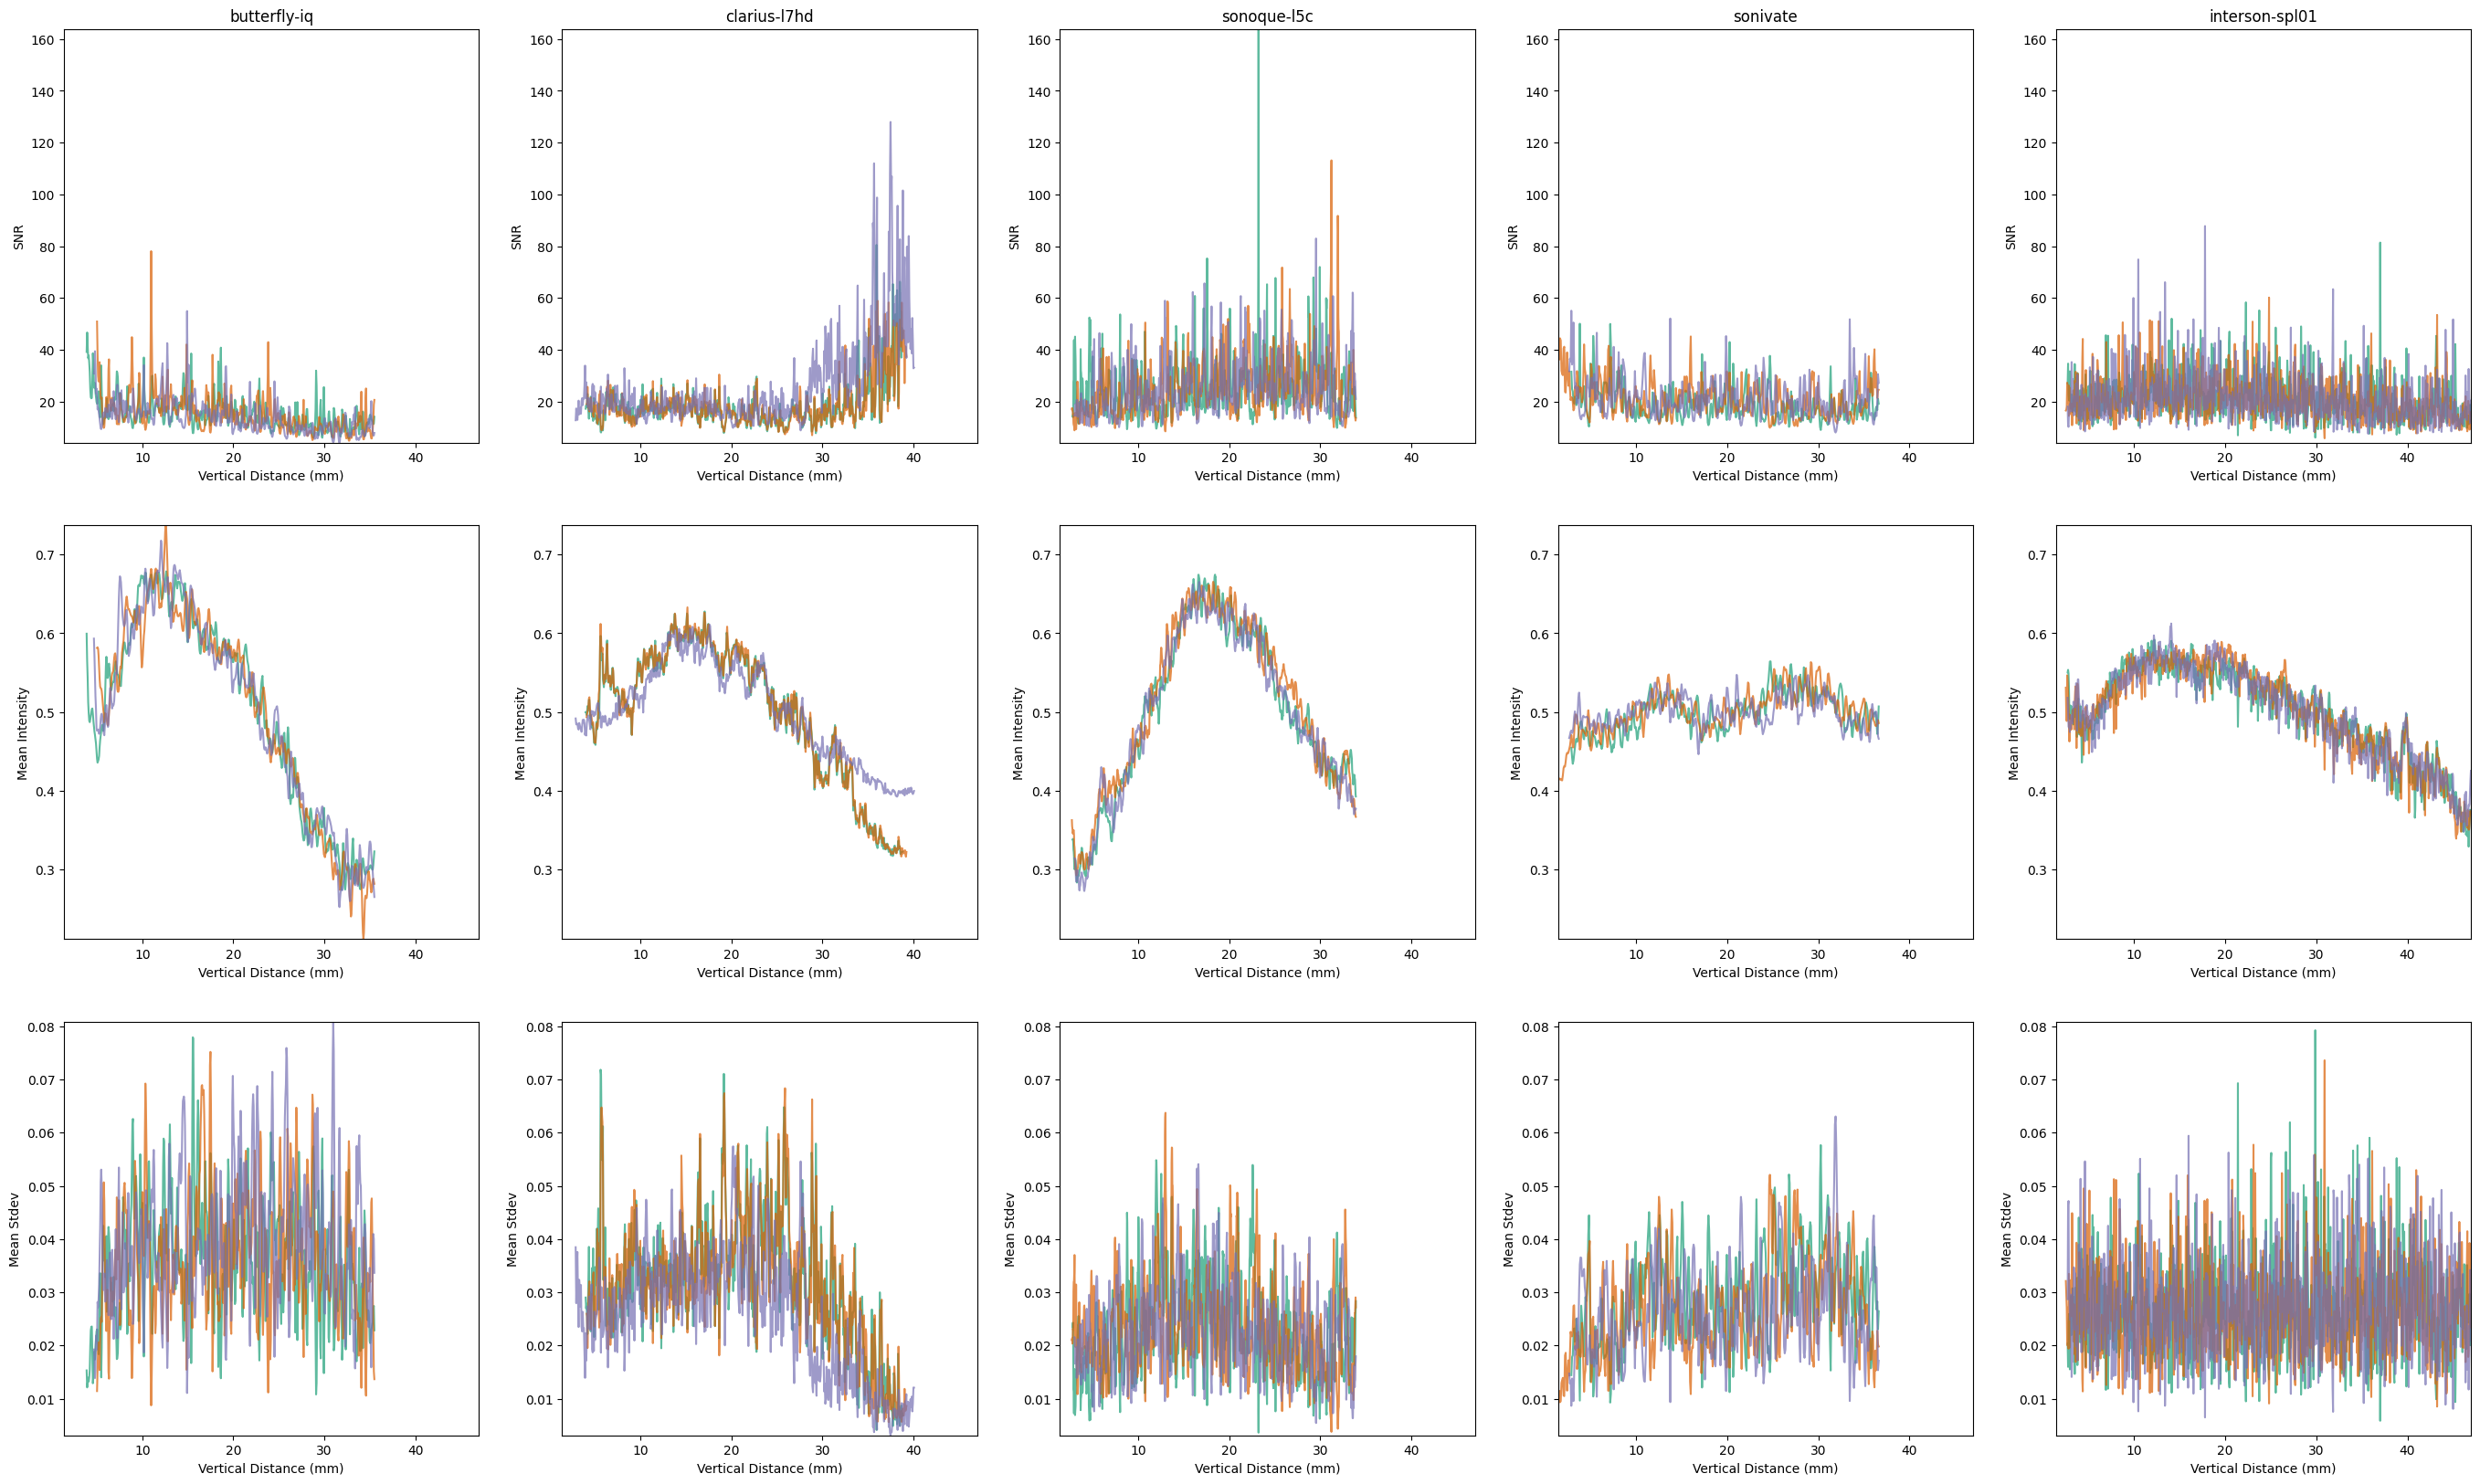

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def get_limits():
    xs = [ k for v in snr_map.values() for x, y in v for k in x]
    ys = [ k for v in snr_map.values() for x, y in v for k in y]
    signals = [ k for v in signal_noise_map.values() for x, y in v for k in x]
    noises = [ k for v in signal_noise_map.values() for x, y in v for k in y]
    return np.min(xs), np.max(xs), np.min(ys), np.max(ys), np.min(signals), np.max(signals), np.min(noises), np.max(noises)

fig, axs = plt.subplots(3, len(probes), figsize=(34,20))

n_r = len(next(iter(snr_map.values()))) # number of replicates, same for all probes
colors = ['#1b9e77','#d95f02','#7570b3']
xmin, xmax, ymin, ymax, smin, smax, nmin, nmax = get_limits()
for i in range(len(probes)):
    k = probes[i]
    
    for j in range(n_r):
        x, y = snr_map[k][j]
        signals, noises = signal_noise_map[k][j]
        axs[0,i].plot(x, y, colors[j], alpha=0.7)
        axs[1,i].plot(x, signals, colors[j], alpha=0.7)
        axs[2,i].plot(x, noises, colors[j], alpha=0.7)
        
    axs[0,i].set_xlim((xmin, xmax))
    axs[0,i].set_ylim((ymin, ymax))
    axs[0,i].set_xlabel('Vertical Distance (mm)')
    axs[0,i].set_ylabel('SNR')
    axs[0,i].set_title(k)
    
    axs[1,i].set_xlim((xmin, xmax))
    axs[1,i].set_ylim((smin, smax))
    axs[1,i].set_xlabel('Vertical Distance (mm)')
    axs[1,i].set_ylabel('Mean Intensity')
    
    axs[2,i].set_xlim((xmin, xmax))
    axs[2,i].set_ylim((nmin, nmax))
    axs[2,i].set_xlabel('Vertical Distance (mm)')
    axs[2,i].set_ylabel('Mean Stdev')
    

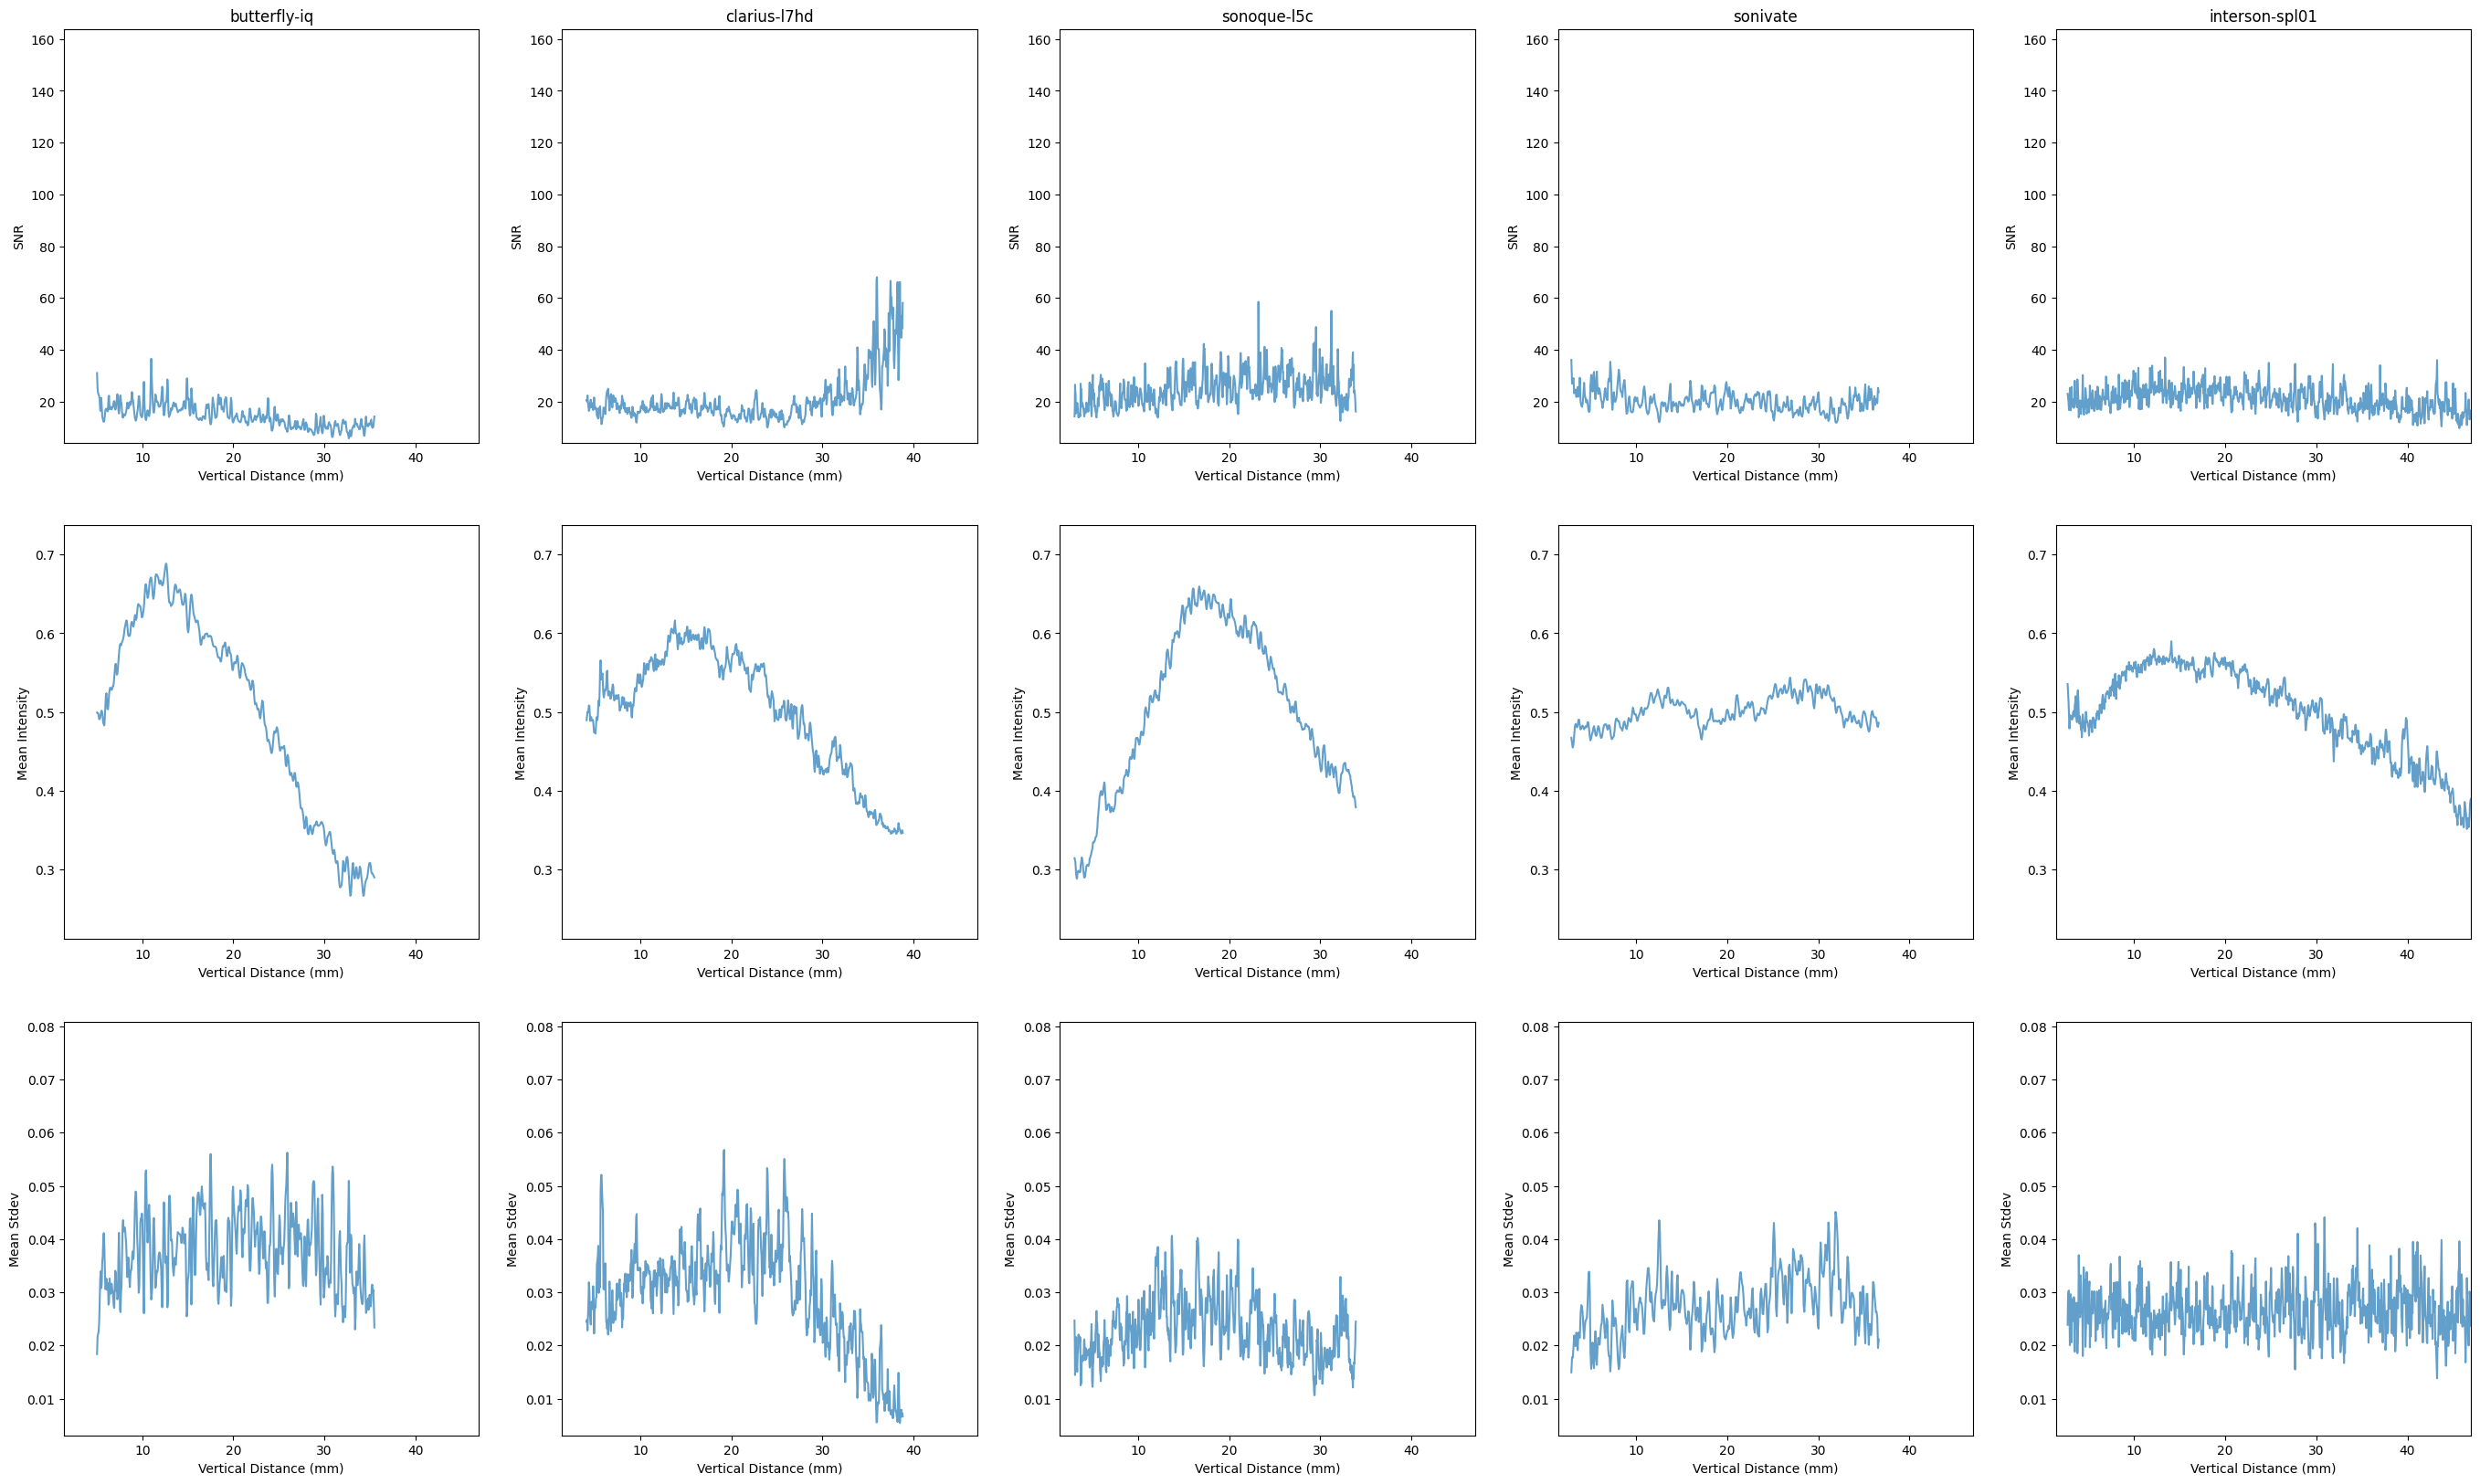

In [5]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
xmin, xmax, ymin, ymax, smin, smax, nmin, nmax = get_limits()

fig, axs = plt.subplots(3, len(probes), figsize=(34,20))

n_r = len(next(iter(snr_map.values()))) # number of replicates, same for all probes
colors = ['#1b9e77','#d95f02','#7570b3']
xmin, xmax, ymin, ymax, smin, smax, nmin, nmax = get_limits()
for i in range(len(probes)):
    k = probes[i]

    xs = [ z[0] for z in snr_map[k] ]
    snrs = [ z[1] for z in snr_map[k] ]
    signals = [ z[0] for z in signal_noise_map[k] ]
    noises = [ z[1] for z in signal_noise_map[k] ]
    
    ts, mean_snr = average_curves(xs, snrs)
    _, mean_signal = average_curves(xs, signals)
    _, mean_noise = average_curves(xs, noises)

    axs[0,i].plot(ts, mean_snr, alpha=0.7)
    axs[1,i].plot(ts, mean_signal, alpha=0.7)
    axs[2,i].plot(ts, mean_noise, alpha=0.7)
        
    axs[0,i].set_xlim((xmin, xmax))
    axs[0,i].set_ylim((ymin, ymax))
    axs[0,i].set_xlabel('Vertical Distance (mm)')
    axs[0,i].set_ylabel('SNR')
    axs[0,i].set_title(k)
    
    axs[1,i].set_xlim((xmin, xmax))
    axs[1,i].set_ylim((smin, smax))
    axs[1,i].set_xlabel('Vertical Distance (mm)')
    axs[1,i].set_ylabel('Mean Intensity')
    
    axs[2,i].set_xlim((xmin, xmax))
    axs[2,i].set_ylim((nmin, nmax))
    axs[2,i].set_xlabel('Vertical Distance (mm)')
    axs[2,i].set_ylabel('Mean Stdev')

In [6]:
import pandas as pd

x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
for i in range(len(probes)):
    k = probes[i]

    xs = [ z[0] for z in snr_map[k] ]
    snrs = [ z[1] for z in snr_map[k] ]
    signals = [ z[0] for z in signal_noise_map[k] ]
    noises = [ z[1] for z in signal_noise_map[k] ]
    
    ts, mean_snr = average_curves(xs, snrs)
    _, mean_signal = average_curves(xs, signals)
    _, mean_noise = average_curves(xs, noises)

    for i in range(len(ts)):
        x1.append(ts[i])
        x2.append(mean_snr[i])
        x3.append(mean_signal[i])
        x4.append(k)
        x5.append(mean_noise[i])
    
df = pd.DataFrame({ 'Probe' : x4, 'Vertical Distance (mm)' : x1, 'SNR' : x2, 'Signal' : x3, 'Noise' : x5 })


<AxesSubplot: xlabel='Vertical Distance (mm)', ylabel='SNR'>

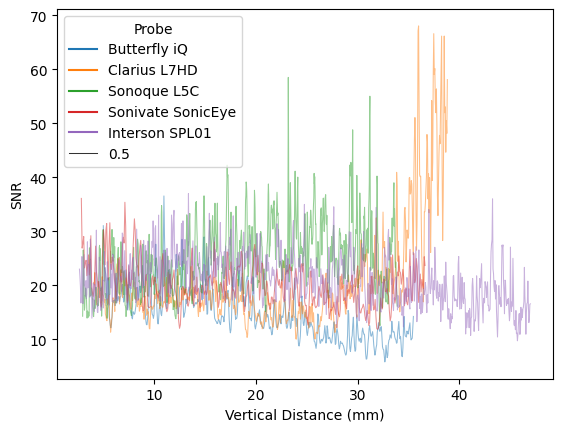

In [7]:
import seaborn as sb
df.replace(PROBE_PRETTY, inplace=True)
df.Probe = pd.Categorical(df.Probe, ordered=True, categories=PROBE_ORDERED)
sb.lineplot(df, x='Vertical Distance (mm)', y='SNR', hue='Probe', alpha=0.5, size=0.5)

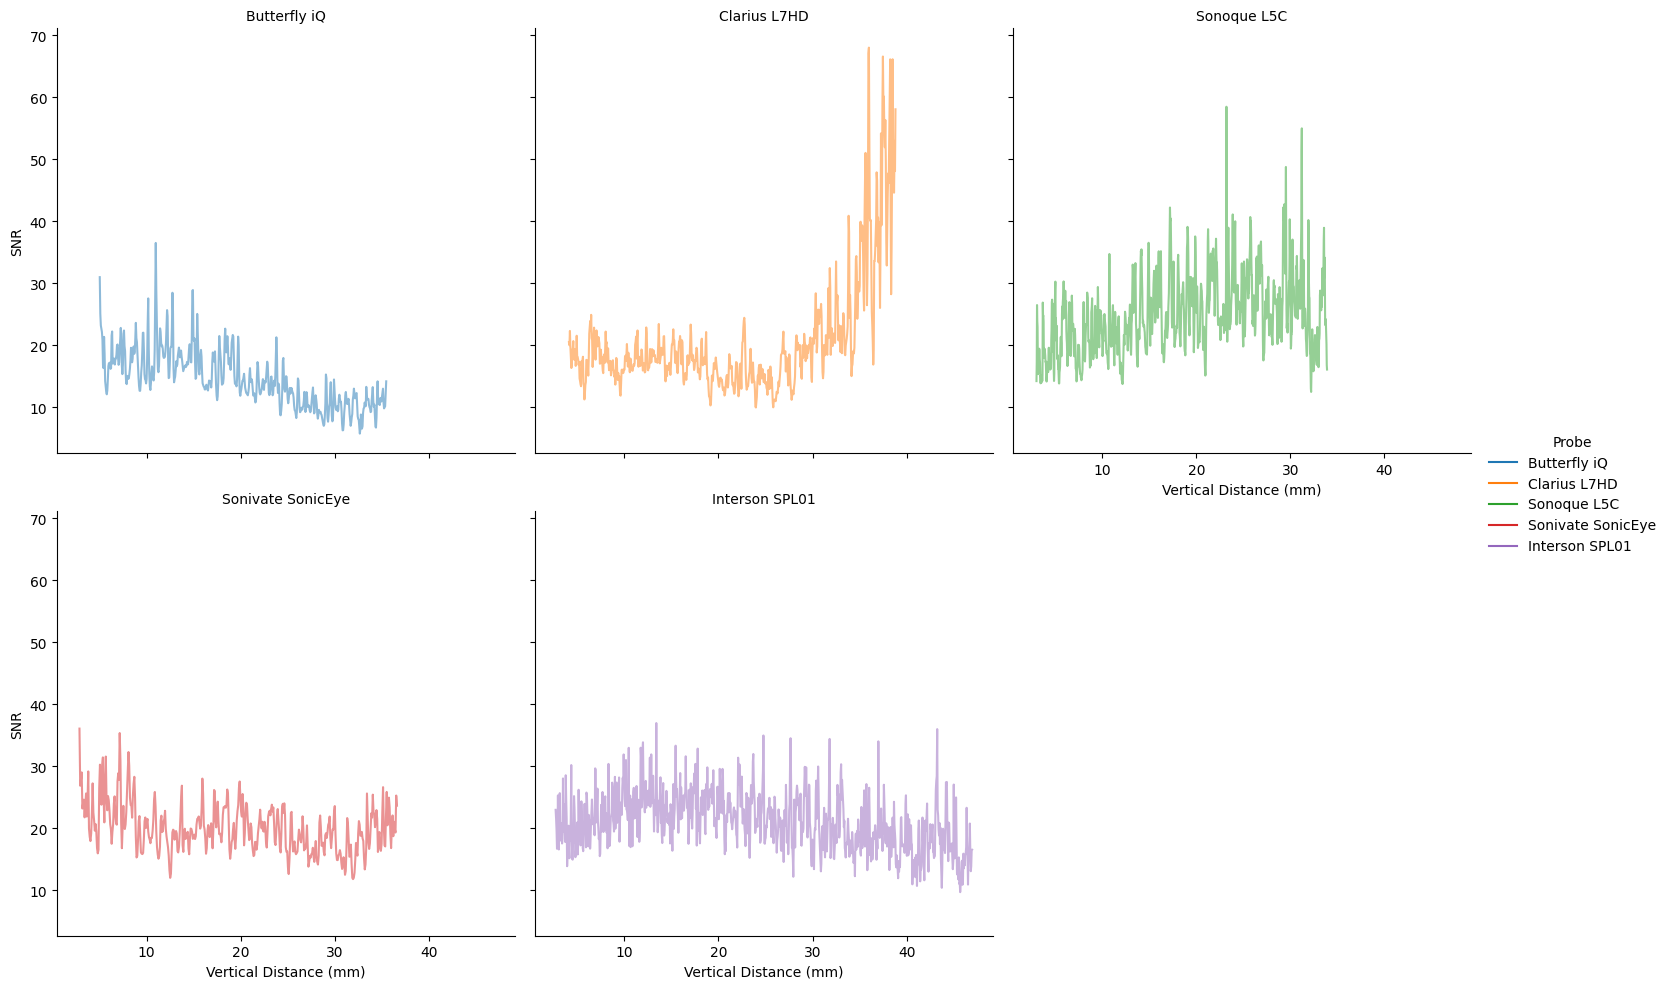

In [8]:
sb.relplot(df, x='Vertical Distance (mm)', y='SNR', hue='Probe', kind='line', alpha=0.5, col='Probe', col_wrap=3).set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-snr-crossprobe.pdf', bbox_inches='tight')

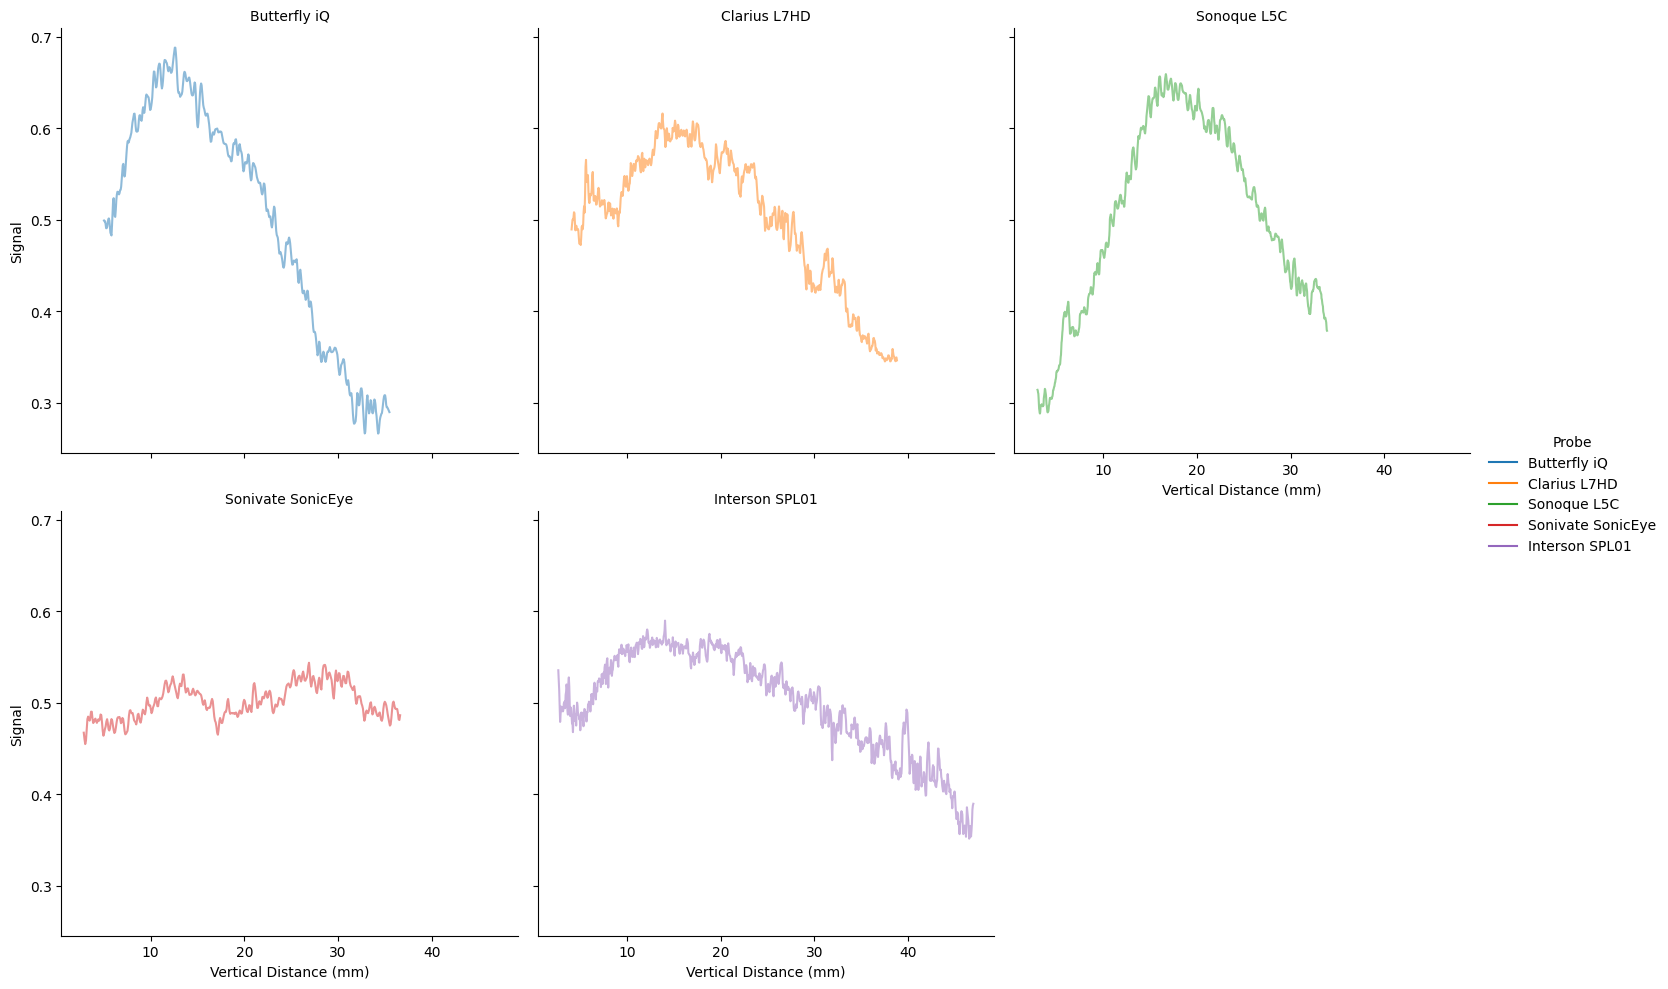

In [9]:
sb.relplot(df, x='Vertical Distance (mm)', y='Signal', hue='Probe', kind='line', alpha=0.5, col='Probe', col_wrap=3).set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-signal-crossprobe.pdf', bbox_inches='tight')

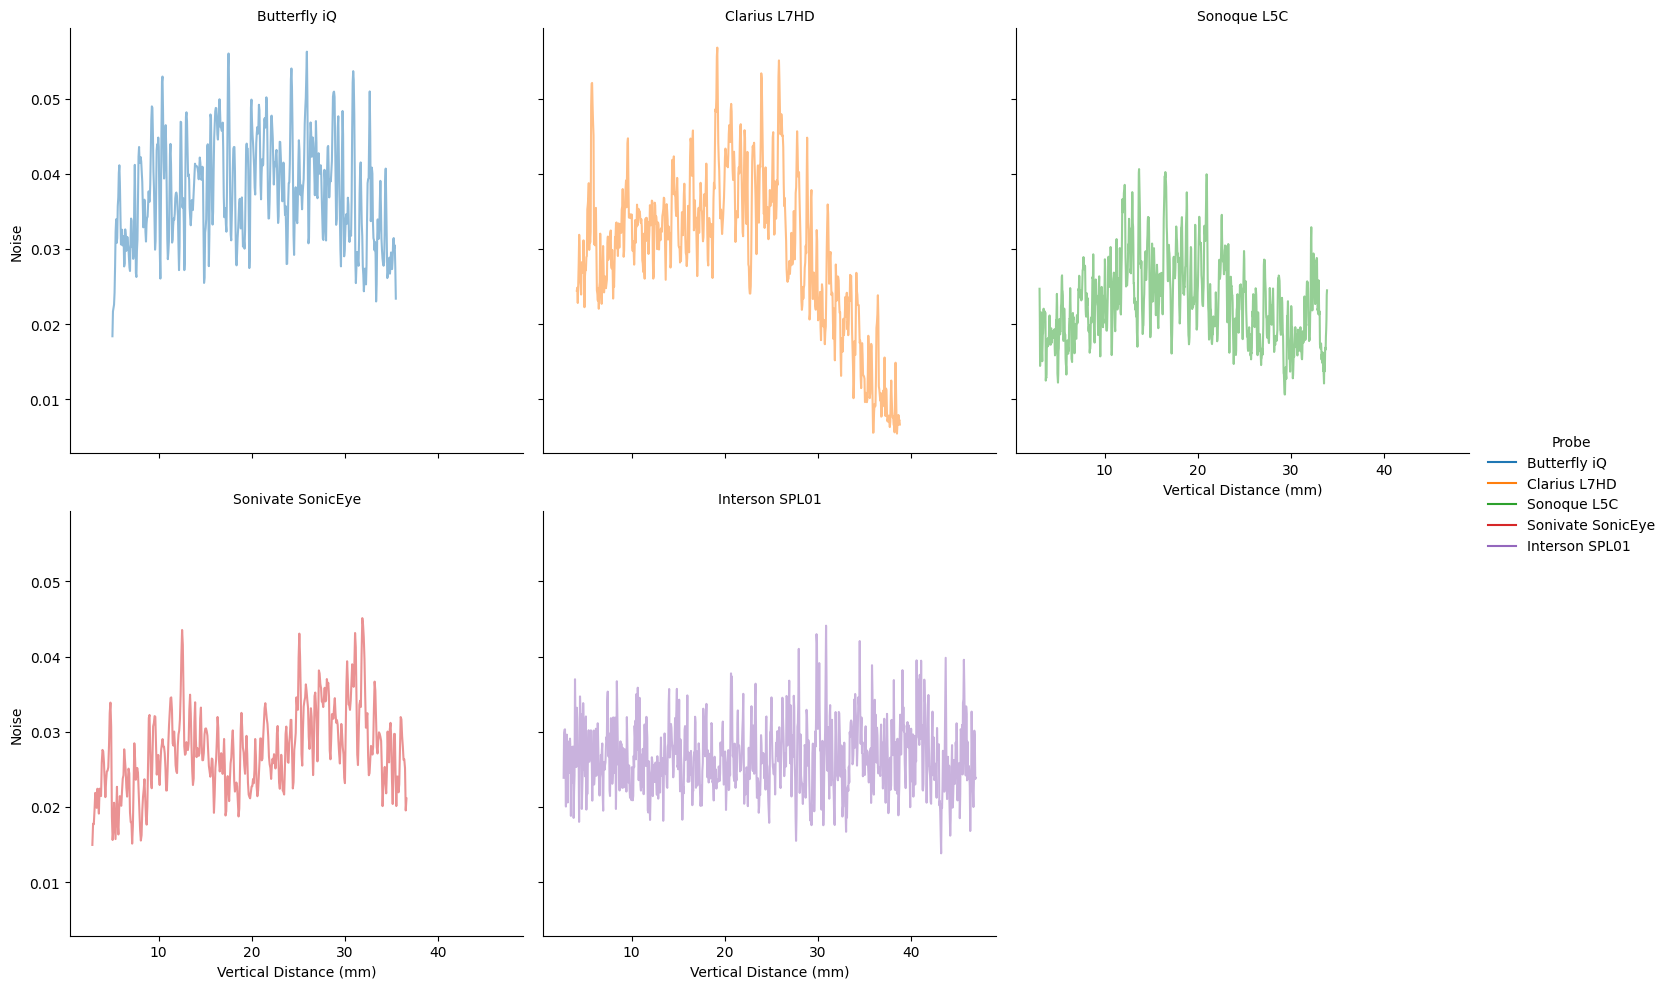

In [10]:
sb.relplot(df, x='Vertical Distance (mm)', y='Noise', hue='Probe', kind='line', alpha=0.5, col='Probe', col_wrap=3).set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-noise-crossprobe.pdf', bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


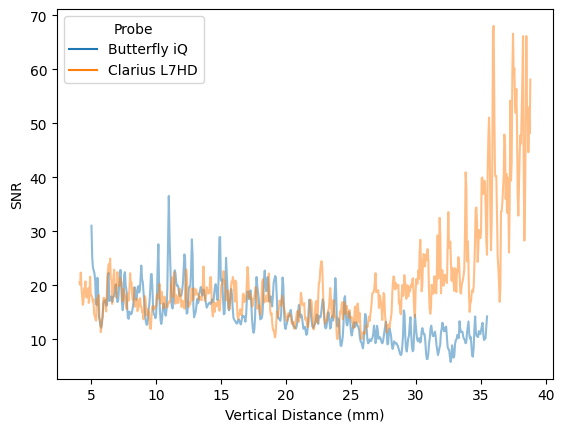

In [11]:
tmp4 = df[df.Probe.isin(['Butterfly iQ', 'Clarius L7HD'])]
tmp4.Probe = pd.Categorical(tmp4.Probe, categories=['Butterfly iQ', 'Clarius L7HD'])
sb.lineplot(tmp4, x='Vertical Distance (mm)', y='SNR', hue='Probe', alpha=0.5)
plt.savefig('../data/phantom_study-202201/analysis/fig-snr-comparison.pdf', bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


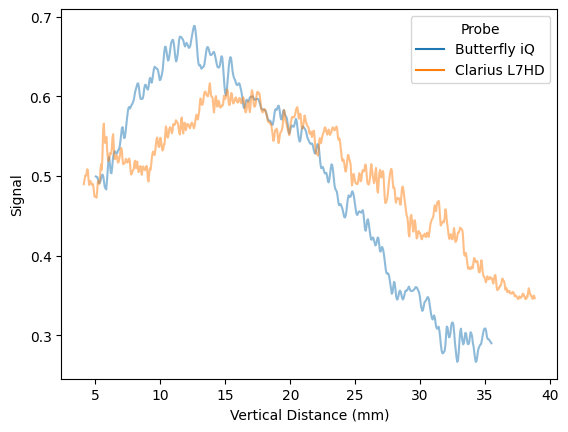

In [12]:
tmp4 = df[df.Probe.isin(['Butterfly iQ', 'Clarius L7HD'])]
tmp4.Probe = pd.Categorical(tmp4.Probe, categories=['Butterfly iQ', 'Clarius L7HD'])

sb.lineplot(tmp4, x='Vertical Distance (mm)', y='Signal', hue='Probe', alpha=0.5)
plt.savefig('../data/phantom_study-202201/analysis/fig-signal-comparison.pdf', bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


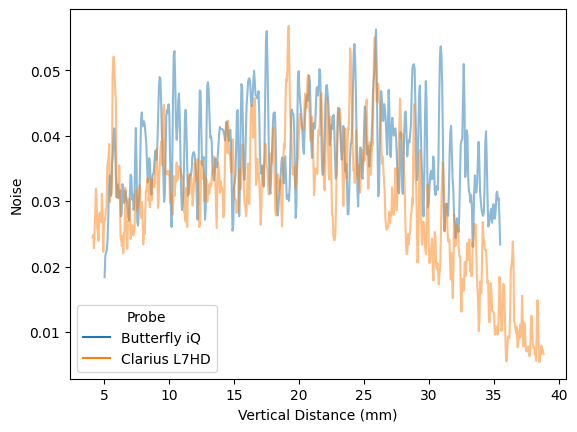

In [13]:
tmp4 = df[df.Probe.isin(['Butterfly iQ', 'Clarius L7HD'])]
tmp4.Probe = pd.Categorical(tmp4.Probe, categories=['Butterfly iQ', 'Clarius L7HD'])

sb.lineplot(tmp4, x='Vertical Distance (mm)', y='Noise', hue='Probe', alpha=0.5)
plt.savefig('../data/phantom_study-202201/analysis/fig-noise-comparison.pdf', bbox_inches='tight')

In [16]:

steps = 5 * np.arange(1,9)
ans = []
for i in np.arange(1, len(steps)):
    tmp = df[(steps[i-1] <= df['Vertical Distance (mm)']) & (df['Vertical Distance (mm)'] < steps[i])]
    tmp2 = tmp.groupby(by='Probe').mean()
    tmp2.reset_index(inplace=True)
    ans.append(tmp2)
    
df_pw = pd.concat(ans)
df_pw.reset_index(inplace=True)


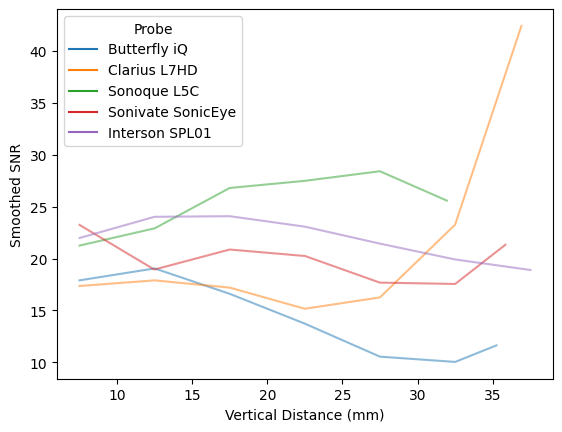

In [18]:
df_pw.rename({ 'SNR' : 'Smoothed SNR' }, axis=1, inplace=True)
sb.lineplot(df_pw, x='Vertical Distance (mm)', y='Smoothed SNR', hue='Probe', alpha=0.5)
plt.savefig('../data/phantom_study-202201/analysis/fig-snr-mean.pdf', bbox_inches='tight')